**Zheng Jintao 55404187**

**Prj05**

Consider the Vasicek model
$$d r_t = \alpha (b - r_t) dt + \sigma dW_t$$
with the following parameters:
$$r_0 = .005, \alpha = 2.11, b = 0.02, \sigma = 0.033.$$

**Todo**

1. Implement Euler simulation and draw a plot of $\mathbb E[ r_t ]$ on $t\in [0, 10]$.
2. Find explicit form of $\mathbb E [r_t]$ and $\lim_{t\to \infty} \mathbb E [r_t]$.
3. Zero bond price has the formula
$P(0, T) = \mathbb E[\exp\{-\int_0^T r(s) ds\}].$
Find the exact value of $P(0,1)$.
4. 
Run Euler, Milstein, exact simulation on $P(0,1)$ with different stepsizes, and find the covergence rate for each using linear regression. (Hint: one shall approximate integral with finite sum)


***
* **discreteSDE**

In [1]:
# %load discreteSDE.py
"""
Simulate 1-d stochastic differential equations numerically using Euler and Milstein Methods
"""
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

class DiscreteSDE( object ):
    """
    initialize:
       Mu: the drift function, univariate.
       Sigma: the diffusion function, univariate.
       Method: a string in ["euler","milstein"].
       Initiate: the starting position of the process.
          methods:sample(t, n): sample the SDE n times until time t.

    """
    def __init__(self, Mu, Sigma, Initiate, Method):
        self.Mu = Mu   # Mu(x , t)dt
        self.Sigma = Sigma  # Sigma(x , t)dWt
        self.Initiate = Initiate
        if Method.lower() not in ["euler", "milstein"]:
            raise Exception("Invalid Method", Method)
        else:
            self.Method = Method

    def PrtCoef(self, x, t):
        print('Method =' + str(self.Method) + '\n')
        print('At state x = ' + str(x) + 'time t = ' + str(t) + '\n')
        print('Mu = ' + str(self.Mu(x, t)) + '\n')
        print('Sigma = '+ str(self.Sigma(x, t)) + '\n')

    def PrtInitiate(self):
        print('Initiate state is ' + str(self.Initiate) + '\n')

    def Sample(self, T, N):
        return getattr(self, self.Method)(T, N)

    def Euler(self, T, N):
        x0 = self.Initiate
        Mu = self.Mu
        Sigma = self.Sigma
        t = np.linspace(0, T, N+1)
        Wh = np.zeros(N+1)  # init BM
        Xh = x0 + np.zeros(N+1) # init Xh

        for i in range(N):
            DeltaT = t[i+1] - t[i]
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
            Xh[i+1] = Xh[i] + Mu(Xh[i], t[i]) * DeltaT + Sigma(Xh[i], t[i]) * DeltaW
        return t, Xh, Wh

    def Milstein(self, T, N, h = 0.001):

        def Sigma_prime(u, v):
            return (self.Sigma(u + h/2, v + h/2) - self.Sigma(u - h/2, v - h/2)) / h

        x0 = self.Initiate
        Mu = self.Mu
        Sigma = self.Sigma
        t = np.linspace(0, T, N + 1)
        Wh = np.zeros(N + 1)  # init BM
        Xh = x0 + np.zeros(N + 1)  # init Xh

        for i in range(N):
            DeltaT = t[i + 1] - t[i]
            DeltaW = np.sqrt(t[i + 1] - t[i]) * np.random.normal()
            Wh[i + 1] = Wh[i] + DeltaW
            Xh[i + 1] = Xh[i] + Mu(Xh[i], t[i]) * DeltaT + Sigma(Xh[i], t[i]) * DeltaW + \
                        0.5 * Sigma_prime(Xh[i], t[i]) * Sigma(Xh[i], t[i]) * (DeltaW ** 2 - DeltaT)
        return t, Xh, Wh

if __name__ == '__main__':
    #std BM
    Mu = lambda x, t : 0.
    Sigma = lambda x, t : 1.
    x0 = 0.
    EulerSDE = DiscreteSDE(Mu, Sigma, x0, "Euler")
    EulerSDE.PrtCoef(0, 1)
    EulerSDE.PrtInitiate()
    plt.figure(1)
    plt.title('Euler Method', color='blue')
    start = perf_counter()
    for i in range(10):
        [t, Y, W] = EulerSDE.Sample(2., 1000);
        plt.plot(t, Y);
    print('Euler Time cost ' + str(perf_counter() - start))

    MilsteinSDE = DiscreteSDE(Mu, Sigma, x0, "Milstein")
    MilsteinSDE.PrtCoef(0, 5)
    MilsteinSDE.PrtInitiate()
    plt.figure(2)
    start = perf_counter()
    for i in range(10):
        [t, Y, W] = MilsteinSDE.Sample(2., 1000);
        plt.plot(t, Y);
    print('Milstein Time cost ' + str(perf_counter() - start))

Method =Euler

At state x = 0time t = 1

Mu = 0.0

Sigma = 1.0

Initiate state is 0.0

Euler Time cost 0.09376196099999845
Method =Milstein

At state x = 0time t = 5

Mu = 0.0

Sigma = 1.0

Initiate state is 0.0

Milstein Time cost 0.13229259799999937


Method =Euler

At state x = 0time t = 1

Mu = 0.0

Sigma = 1.0

Initiate state is 0.0

Euler Time cost 0.09003283099999493
Method =Milstein

At state x = 0time t = 5

Mu = 0.0

Sigma = 1.0

Initiate state is 0.0

Milstein Time cost 0.1400810059999955


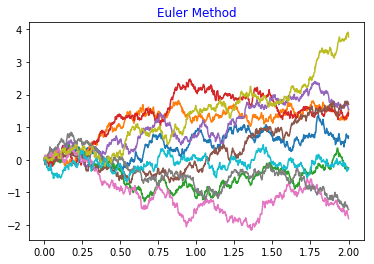

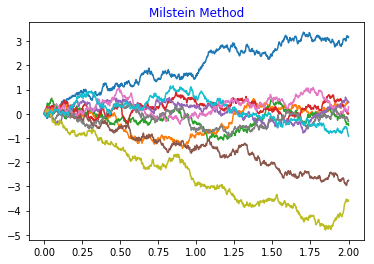

In [2]:
%run discreteSDE.py

***
**1. Euler simulation and  a plot of $\mathbb E[ r_t ]$**

In [3]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from discreteSDE import *
from time import perf_counter
plt.style.use('seaborn')

#define function Mu and Sigma
r0 = .005
alpha = 2.11
b = .02
sig = .033
Mu = lambda x, t : alpha * (b - x)
Sigma = lambda x,t : sig
x0 = r0

Time cost 3.502906968000005 s


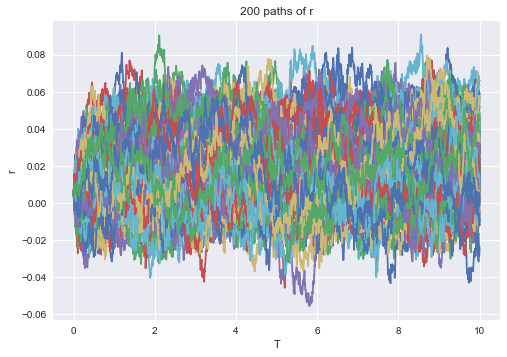

In [4]:
T = 10
MeshL = .005
SampleNum = 200
MeshNum = int(T/MeshL)

start = perf_counter()
for n in range(SampleNum):
    EulerSDE = DiscreteSDE(Mu, Sigma, x0, "Euler")
    [t, r, Wh] = EulerSDE.Sample(T, MeshNum)
    plt.plot(t,r)
plt.title(str(SampleNum)+' paths of r')
plt.xlabel('T')
plt.ylabel('r')  
print('Time cost '+str(perf_counter()-start)+' s')

* One path of the $\mathbb E[ r_t ]$

Time cost 0.2640095759999994 s


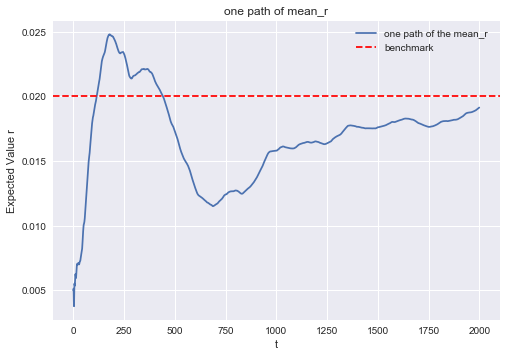

In [5]:
rpath = []
r_mean = np.zeros(MeshNum)
start = perf_counter()
for i in range(MeshNum):
    rpath.append(r[i])
    r_mean[i]=np.mean(rpath)
plt.title('one path of mean_r')
plt.plot(range(MeshNum), r_mean,label='one path of the mean_r ')
plt.axhline(b, color='r', ls='dashed', label='benchmark')
plt.xlabel('t')
plt.ylabel('Expected Value r')
plt.legend()
print('Time cost ' + str(perf_counter() - start)+' s')

* Considering all path to calculate $\mathbb E[ r_t ]$

In [6]:
start = perf_counter()
r_matrix = np.zeros(shape=[SampleNum, MeshNum])
for i in range(SampleNum):
    [t, r, Wh] = EulerSDE.Sample(T, MeshNum)
    rpath = []
    for j in range(MeshNum):
        rpath.append(r[j])
        r_mean[j] = np.mean(rpath)
    r_matrix[i,] = r_mean

Time cost 42.657887388 s


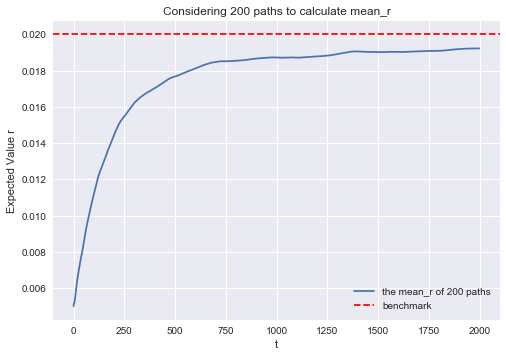

In [7]:
r_matrix_mean = np.mean(r_matrix, axis=0) #calculate the mean of each column
plt.title('Considering '+str(SampleNum)+' paths to calculate mean_r')
plt.plot(range(MeshNum), r_matrix_mean,label='the mean_r of '+str(SampleNum)+' paths')
plt.axhline(b, color='r', ls='dashed', label='benchmark')
plt.xlabel('t')
plt.ylabel('Expected Value r')
plt.legend()
print('Time cost ' + str(perf_counter() - start)+' s')

***
**2. Explicit form of $\mathbb E [r_t]$ and $\lim_{t\to \infty} \mathbb E [r_t]$**

$$d r_t = \alpha (b - r_t) dt + \sigma dW_t$$
**Solution of $\mathbb E [r_t]$**

(i) Using the SDE above and multiplying both sides by $e^{\alpha t}$, we have that,

$$
\begin{align*}
e^{\alpha t}dr_{t}&= \alpha \left ( b-r_{t} \right )e^{\alpha t}dt+\sigma e^{\alpha t}dW_{t} \\
e^{\alpha t}dr_{t}+r_{t}\alpha e^{\alpha t}dt&= \alpha b e^{\alpha t}dt+\sigma e^{\alpha t}dW_{t} \\
d \left ( e^{\alpha t}r_{t} \right )&=\alpha b e^{\alpha t}dt+\sigma e^{\alpha t}dW_{t} \\
e^{\alpha t}r_{t}&=r_{0}+\alpha b \int_{0}^{t}e^{\alpha s}ds + \sigma \int_{0}^{t}e^{\alpha s}dW_{s} \\
r_{t}&=r_{0}e^{-\alpha t}+\alpha b \int_{0}^{t}e^{-\alpha \left ( t-s \right )}ds + \sigma \int_{0}^{t}e^{-\alpha \left ( t-s \right )}dW_{s}
\end{align*}
$$

(ii) Using $It\hat{o}$ 's formula, define $F\left ( t, r_{t} \right )=e^{\alpha t}r_{t}$, then
$$
\left\{\begin{align}
\frac{\partial F}{\partial t}&=\alpha e^{\alpha t}r_{t}\\ 
\frac{\partial F}{\partial r_{t}}&=e^{\alpha t}\\ 
\frac{\partial ^{2}F}{\partial r_{t}^{2}}&=0
\end{align}\right.
$$
Applying Itô's lemma yields
$$
\begin{align*}
dF\left ( t, r_{t} \right )&=(\alpha e^{\alpha t}r_{t}+\alpha \left ( b-r_{t} \right )e^{\alpha t})dt+\sigma e^{\alpha t}dW_{t} \\
&=\alpha be^{\alpha t}dt+\sigma e^{\alpha t}dW_{t}
\end{align*}
$$
then get integral form like (i)
$$
r_{t}=r_{0}e^{-\alpha t}+\alpha b \int_{0}^{t}e^{-\alpha \left ( t-s \right )}ds + \sigma \int_{0}^{t}e^{-\alpha \left ( t-s \right )}dW_{s}
$$


The first integral is deterministic and just a number. The second integral is a stoch. Ito integral with a deterministic integrand and therefore Gaussian,with mean 0 and variance  $\sigma^{2} \int_{0}^{t}e^{-2\alpha \left ( t-s \right )}ds$; hence $r_t$ is Gaussian with mean and variance:
$$ \mathbb{E}[r_{t}]=r_{0}e^{-\alpha t}+ b\left ( 1-e^{-\alpha t} \right )$$
$$ \mathbb{V}[r_{t}]=\sigma ^{2}e^{-2\alpha t}\int_{0}^{t}e^{-2\alpha s}ds= \frac{\sigma ^{2}}{2\alpha }\left ( 1- e^{-2\alpha t}\right )$$

  

**$\lim_{t\to \infty} \mathbb E [r_t]$**

As t $\rightarrow \infty$, we have
$$
\begin{align*}
\lim_{t\rightarrow \infty }\mathbb{E}[r_{t}]&=r_{0}\lim_{t\rightarrow \infty }e^{-\alpha t}+b(1- \lim_{t\rightarrow \infty }e^{-\alpha t})=b \\
\lim_{t\rightarrow \infty }\mathbb{V}[r_{t}]&=\frac{\sigma ^{2}}{2\alpha }(1- \lim_{t\rightarrow \infty }e^{-\alpha t})=\frac{\sigma ^{2}}{2\alpha }
\end{align*}
$$
So, $\mathbf{N}[b,\frac{\sigma ^{2}}{2\alpha }]$ is the limiting distribution of $r_t$.

***
**3. Zero bond price**

The bond price is given by affine rate model
$$
\begin{align*}
Bond(t,T,r_t)&=e^{A(t,T)-B(t,T)r_t} \\
\\
A(t,T)&=(B(t,T)-(T-t))(b-\frac{\sigma ^{2}}{2\alpha ^{2}})-\frac{\sigma ^{2}}{4\alpha }B^{2}(t,T) \\
B(t,T)&=\frac{1-e^{-\alpha (T-t)}}{\alpha }
\end{align*}
$$


In [8]:
B = lambda t, T : (1 - np.exp( -1 * alpha * (T-t)))/alpha
A = lambda t,T : (B(t,T) - (T-t)) * (b-sig**2/(2*alpha**2))-sig**2/(4*alpha)*(B(t,T))**2
Bond = lambda t, T : np.exp(A(t,T)-B(t,T)*r0)
Bond(0,1)

0.9863895803459704

The exat value of P(0,1) is 0.9863895803459704

***
**4. The covergence rate**

$$r_{t}=r_{0}e^{-\alpha t}+b(1-e^{-\alpha t}) + \sqrt{\frac{\sigma ^{2}}{2\alpha }\left ( 1- e^{-2\alpha t}\right )}Z$$
$$where Z\sim N(0,1) $$

In [9]:
#define function Mu and Sigma
r0 = .005
alpha = 2.11
b = .02
sig = .033
Mu = lambda x, t : alpha * (b - x)
Sigma = lambda x,t : sig

ExactSim Time cost 0.3326443849999947


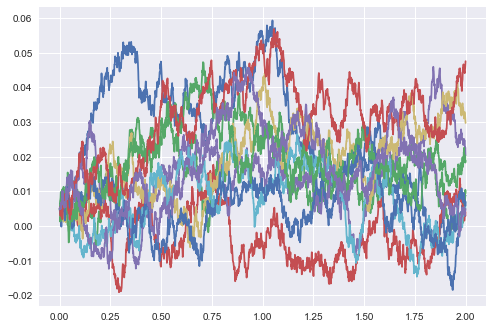

In [10]:
def ExactSim(alpha, b, sig, r0, T, N):
    t = np.linspace(0, T, N+1)
    rh = r0 + np.zeros(N+1)
    for i in range(N):
        DeltaT = t[i+1] - t[i]
        rh[i+1] = rh[i] * np.exp(-alpha * DeltaT) + b * (1 - np.exp(-alpha * DeltaT)) + \
                  np.sqrt(sig**2 / (2 * alpha) * (1 - np.exp(-2 * alpha * DeltaT))) * np.random.normal()
    return t, rh


start = perf_counter()
for i in range(10):
    [t, rh] = ExactSim(alpha, b, sig, r0, 2, 2000);
    plt.plot(t, rh);
print('ExactSim Time cost ' + str(perf_counter() - start))    

In [11]:
ArrLog2Steps = np.arange(8)
NumMinLog2Steps = 4 
T = 1.
SampleNum = 100

ArrErr_Euler = np.zeros(ArrLog2Steps.size)
ArrErr_Milstein = np.zeros(ArrLog2Steps.size)
ArrErr_ExactSim = np.zeros(ArrLog2Steps.size)

EulerSDE = DiscreteSDE(Mu, Sigma, r0, "Euler")
MilsteinSDE = DiscreteSDE(Mu, Sigma, r0, "Milstein")

In [12]:
deltaT = T / 10000
for n in ArrLog2Steps:
    
    NumMesh = np.power(2, n + NumMinLog2Steps)
    errsum_Euler = 0
    errsum_Milstein = 0
    errsum_ExactSim = 0
    
    for i in range(SampleNum):
        
        #Euler
        [t, rh, Wh] = EulerSDE.Sample(T, NumMesh)
        PT = np.exp(-1 * np.sum(rh) * deltaT)
        P = Bond(0,T)
        errsum_Euler = errsum_Euler + np.abs(PT - P)
        #plt.plot(t,rh)
        
        #Milstein
        [t2, rh2, Wh2] = MilsteinSDE.Sample(T, NumMesh)
        PT = np.exp(-1 * np.sum(rh2) * deltaT)
        P = Bond(0,T)
        errsum_Milstein = errsum_Milstein + np.abs(PT - P)
        #plt.plot(t2,rh2)
        
        #ExactSim
        [t3, rh3] = ExactSim(alpha, b, sig, r0, T, NumMesh)
        PT = np.exp(-1 * np.sum(rh3) * deltaT)
        P = Bond(0,T)
        errsum_ExactSim = errsum_ExactSim + np.abs(PT - P)
        #plt.plot(t3,rh3)
        
    ArrErr_Euler[n] = errsum_Euler/SampleNum
    ArrErr_Milstein[n] = errsum_Milstein/SampleNum
    ArrErr_ExactSim[n] = errsum_ExactSim/SampleNum
    

* Calculate the covergence rate for each using linear regression

rate_Euler is 0.02972192541845991
rate_Milstein is 0.029130047563040367
rate_ExactSim is 0.02740407710097504


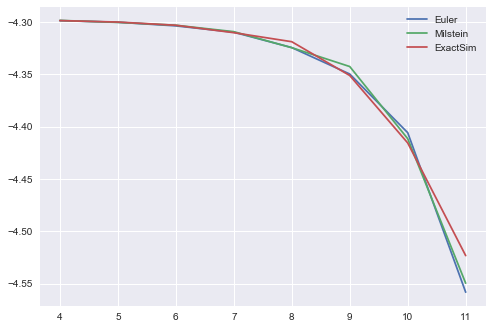

In [13]:
from scipy import stats

x_coordinate = ArrLog2Steps+NumMinLog2Steps

y_coordinate_Euler = np.log(ArrErr_Euler)
y_coordinate_Milstein = np.log(ArrErr_Milstein)
y_coordinate_ExactSim = np.log(ArrErr_ExactSim)

plt.plot(x_coordinate, y_coordinate_Euler,label = "Euler")
plt.plot(x_coordinate, y_coordinate_Milstein,label = "Milstein")
plt.plot(x_coordinate, y_coordinate_ExactSim,label = "ExactSim")
plt.legend()

lg_Euler = stats.linregress(x_coordinate,y_coordinate_Euler)
lg_Milstein = stats.linregress(x_coordinate,y_coordinate_Milstein)
lg_ExactSim = stats.linregress(x_coordinate,y_coordinate_ExactSim)

rate_Euler = -lg_Euler[0]
rate_Milstein = -lg_Milstein[0]
rate_ExactSim = -lg_ExactSim[0]

print('rate_Euler is '+ str(rate_Euler))
print('rate_Milstein is '+ str(rate_Milstein))
print('rate_ExactSim is '+ str(rate_ExactSim)) 